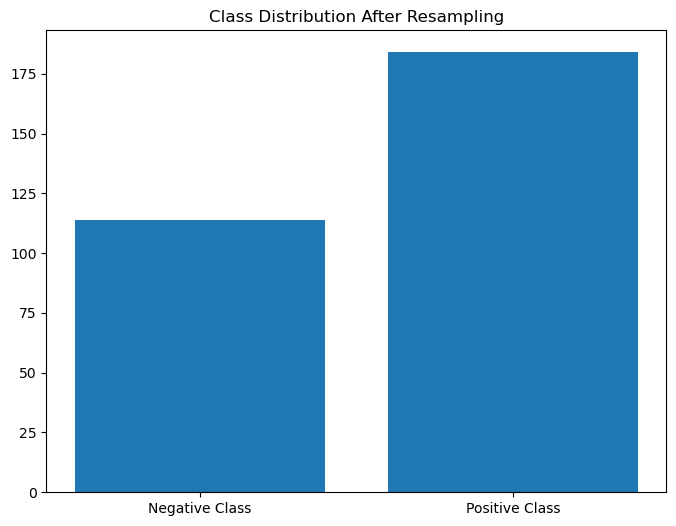

RandomForest AUC: 0.9949
XGBoost AUC: 0.9930
Logistic Regression AUC: 0.9157
Optimal Threshold for RandomForest: 0.31
RandomForest Test Accuracy: 0.84
RandomForest Test Precision: 0.00
RandomForest Test Recall: 0.00
RandomForest Test AUC: 0.58


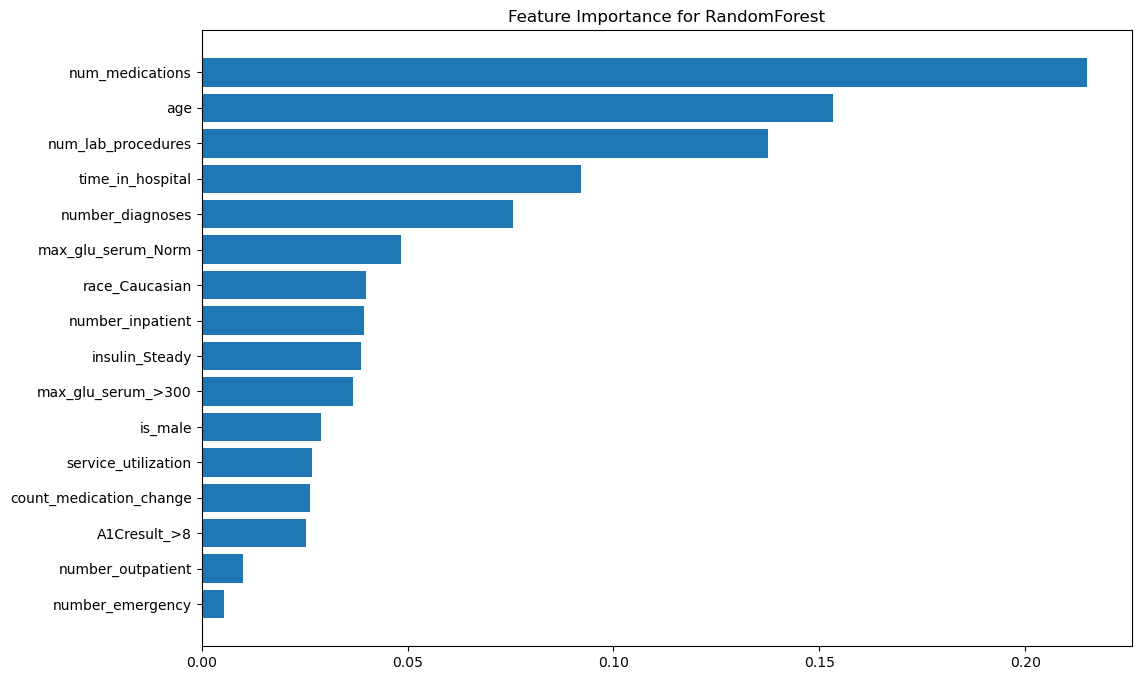

100%|████████| 50/50 [01:42<00:00,  2.04s/trial, best loss: -0.9961774026991419]
Best parameters after mapping: {'lr__C': 2.387616782239497, 'rf__n_estimators': 200, 'rf__max_depth': 30, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.08652245511443922}


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import StackingClassifier

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses', 'A1Cresult_>8', 'race_Caucasian',
    'is_male', 'insulin_Steady', 'count_medication_change', 'max_glu_serum_>300',
    'service_utilization', 'number_emergency', 'number_outpatient', 'number_inpatient'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Check class distribution in the training set
plt.figure(figsize=(8, 6))
plt.bar(['Negative Class', 'Positive Class'], [sum(y_train_res == 0), sum(y_train_res == 1)])
plt.title('Class Distribution After Resampling')
plt.show()

# Define individual models
rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.4738, use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(C=1.252, max_iter=1000, random_state=42)

# Cross-validation for individual models
rf_scores = cross_val_score(rf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
xgb_scores = cross_val_score(xgb, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
lr_scores = cross_val_score(lr, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)

print(f'RandomForest AUC: {rf_scores.mean():.4f}')
print(f'XGBoost AUC: {xgb_scores.mean():.4f}')
print(f'Logistic Regression AUC: {lr_scores.mean():.4f}')

# Train a simpler model
rf.fit(X_train_res_scaled, y_train_res)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the simpler model
thresholds = np.linspace(0, 1, 101)
optimal_threshold_rf = 0.0
best_f1_rf = 0.0

for threshold in thresholds:
    y_pred_rf = (y_pred_proba_rf >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, zero_division=0)
    recall = recall_score(y_test, y_pred_rf, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    if f1 > best_f1_rf:
        best_f1_rf = f1
        optimal_threshold_rf = threshold

print(f"Optimal Threshold for RandomForest: {optimal_threshold_rf:.2f}")
print(f"RandomForest Test Accuracy: {accuracy:.2f}")
print(f"RandomForest Test Precision: {precision:.2f}")
print(f"RandomForest Test Recall: {recall:.2f}")
print(f"RandomForest Test AUC: {roc_auc_score(y_test, y_pred_proba_rf):.2f}")

# Feature importance for RandomForest
feature_importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for RandomForest')
plt.gca().invert_yaxis()
plt.show()

# Define StackingClassifier with the base learners
estimators = [('rf', rf), ('xgb', xgb), ('lr', lr)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=42))

# Define hyperparameter space
space_refined = {
    'lr__C': hp.loguniform('lr__C', -2, 2),
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.loguniform('xgb__learning_rate', -3, 0)
}

def objective(params):
    # Update model parameters
    stacking_clf.set_params(**params)
    return -cross_val_score(stacking_clf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5).mean()

# Initialize trials object
trials = Trials()

# Perform hyperparameter tuning
best = fmin(fn=objective,
            space=space_refined,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

# Map best parameters back to their proper names
best_params = {
    'lr__C': best['lr__C'],
    'rf__n_estimators': [50, 100, 200][best['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best['xgb__max_depth']],
    'xgb__learning_rate': best['xgb__learning_rate']
}

print("Best parameters after mapping:", best_params)

# Retrain the best model with optimal parameters
stacking_clf.set_params(**best_params)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
optimal_threshold = 0.0


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import StackingClassifier

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses', 'A1Cresult_>8', 'race_Caucasian',
    'is_male', 'insulin_Steady', 'count_medication_change', 'max_glu_serum_>300',
    'service_utilization', 'number_emergency', 'number_outpatient', 'number_inpatient'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define individual models
rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.4738, use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(C=1.252, max_iter=1000, random_state=42)

# Cross-validation for individual models
rf_scores = cross_val_score(rf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
xgb_scores = cross_val_score(xgb, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
lr_scores = cross_val_score(lr, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)

print(f'RandomForest AUC: {rf_scores.mean():.4f}')
print(f'XGBoost AUC: {xgb_scores.mean():.4f}')
print(f'Logistic Regression AUC: {lr_scores.mean():.4f}')

# Train a simpler model
rf.fit(X_train_res_scaled, y_train_res)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the simpler model
thresholds = np.linspace(0, 1, 101)
optimal_threshold_rf = 0.0
best_f1_rf = 0.0

for threshold in thresholds:
    y_pred_rf = (y_pred_proba_rf >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, zero_division=0)
    recall = recall_score(y_test, y_pred_rf, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    if f1 > best_f1_rf:
        best_f1_rf = f1
        optimal_threshold_rf = threshold

print(f"Optimal Threshold for RandomForest: {optimal_threshold_rf:.2f}")
print(f"RandomForest Test Accuracy: {accuracy:.2f}")
print(f"RandomForest Test Precision: {precision:.2f}")
print(f"RandomForest Test Recall: {recall:.2f}")
print(f"RandomForest Test AUC: {roc_auc_score(y_test, y_pred_proba_rf):.2f}")

# Feature importance for RandomForest
feature_importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for RandomForest')
plt.gca().invert_yaxis()
plt.show()

# Define StackingClassifier with the base learners
estimators = [('rf', rf), ('xgb', xgb), ('lr', lr)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=42))

# Define hyperparameter space
space_refined = {
    'lr__C': hp.loguniform('lr__C', -2, 2),
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.loguniform('xgb__learning_rate', -3, 0)
}

def objective(params):
    # Update model parameters
    stacking_clf.set_params(**params)
    return -cross_val_score(stacking_clf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5).mean()

# Initialize trials object
trials = Trials()

# Perform hyperparameter tuning
best = fmin(fn=objective,
            space=space_refined,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

# Map best parameters back to their proper names
best_params = {
    'lr__C': best['lr__C'],
    'rf__n_estimators': [50, 100, 200][best['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best['xgb__max_depth']],
    'xgb__learning_rate': best['xgb__learning_rate']
}

print("Best parameters after mapping:", best_params)

# Retrain the best model with optimal parameters
stacking_clf.set_params(**best_params)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
optimal_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_div &#8203;:citation[【oaicite:0】]&#8203;


SyntaxError: incomplete input (4158470803.py, line 167)

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import StackingClassifier

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses', 'A1Cresult_>8', 'race_Caucasian',
    'is_male', 'insulin_Steady', 'count_medication_change', 'max_glu_serum_>300',
    'service_utilization', 'number_emergency', 'number_outpatient', 'number_inpatient'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define individual models
rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.4738, use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(C=1.252, max_iter=1000, random_state=42)

# Cross-validation for individual models
rf_scores = cross_val_score(rf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
xgb_scores = cross_val_score(xgb, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
lr_scores = cross_val_score(lr, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)

print(f'RandomForest AUC: {rf_scores.mean():.4f}')
print(f'XGBoost AUC: {xgb_scores.mean():.4f}')
print(f'Logistic Regression AUC: {lr_scores.mean():.4f}')

# Train a simpler model
rf.fit(X_train_res_scaled, y_train_res)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the simpler model
thresholds = np.linspace(0, 1, 101)
optimal_threshold_rf = 0.0
best_f1_rf = 0.0

for threshold in thresholds:
    y_pred_rf = (y_pred_proba_rf >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, zero_division=0)
    recall = recall_score(y_test, y_pred_rf, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    if f1 > best_f1_rf:
        best_f1_rf = f1
        optimal_threshold_rf = threshold

print(f"Optimal Threshold for RandomForest: {optimal_threshold_rf:.2f}")
print(f"RandomForest Test Accuracy: {accuracy:.2f}")
print(f"RandomForest Test Precision: {precision:.2f}")
print(f"RandomForest Test Recall: {recall:.2f}")
print(f"RandomForest Test AUC: {roc_auc_score(y_test, y_pred_proba_rf):.2f}")

# Feature importance for RandomForest
feature_importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for RandomForest')
plt.gca().invert_yaxis()
plt.show()

# Define StackingClassifier with the base learners
estimators = [('rf', rf), ('xgb', xgb), ('lr', lr)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=42))

# Define hyperparameter space
space_refined = {
    'lr__C': hp.loguniform('lr__C', -2, 2),
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.loguniform('xgb__learning_rate', -3, 0)
}

def objective(params):
    # Update model parameters
    stacking_clf.set_params(**params)
    return -cross_val_score(stacking_clf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5).mean()

# Initialize trials object
trials = Trials()

# Perform hyperparameter tuning
best = fmin(fn=objective,
            space=space_refined,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

# Map best parameters back to their proper names
best_params = {
    'lr__C': best['lr__C'],
    'rf__n_estimators': [50, 100, 200][best['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best['xgb__max_depth']],
    'xgb__learning_rate': best['xgb__learning_rate']
}

print("Best parameters after mapping:", best_params)

# Retrain the best model with optimal parameters
stacking_clf.set_params(**best_params)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
optimal_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 


SyntaxError: invalid syntax (298864365.py, line 168)

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import StackingClassifier

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses', 'A1Cresult_>8', 'race_Caucasian',
    'is_male', 'insulin_Steady', 'count_medication_change', 'max_glu_serum_>300',
    'service_utilization', 'number_emergency', 'number_outpatient', 'number_inpatient'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define individual models
rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.4738, use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(C=1.252, max_iter=1000, random_state=42)

# Cross-validation for individual models
rf_scores = cross_val_score(rf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
xgb_scores = cross_val_score(xgb, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
lr_scores = cross_val_score(lr, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)

print(f'RandomForest AUC: {rf_scores.mean():.4f}')
print(f'XGBoost AUC: {xgb_scores.mean():.4f}')
print(f'Logistic Regression AUC: {lr_scores.mean():.4f}')

# Train a simpler model
rf.fit(X_train_res_scaled, y_train_res)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the simpler model
thresholds = np.linspace(0, 1, 101)
optimal_threshold_rf = 0.0
best_f1_rf = 0.0

for threshold in thresholds:
    y_pred_rf = (y_pred_proba_rf >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, zero_division=0)
    recall = recall_score(y_test, y_pred_rf, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    if f1 > best_f1_rf:
        best_f1_rf = f1
        optimal_threshold_rf = threshold

print(f"Optimal Threshold for RandomForest: {optimal_threshold_rf:.2f}")
print(f"RandomForest Test Accuracy: {accuracy:.2f}")
print(f"RandomForest Test Precision: {precision:.2f}")
print(f"RandomForest Test Recall: {recall:.2f}")
print(f"RandomForest Test AUC: {roc_auc_score(y_test, y_pred_proba_rf):.2f}")

# Feature importance for RandomForest
feature_importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for RandomForest')
plt.gca().invert_yaxis()
plt.show()

# Define StackingClassifier with the base learners
estimators = [('rf', rf), ('xgb', xgb), ('lr', lr)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=42))

# Define hyperparameter space
space_refined = {
    'lr__C': hp.loguniform('lr__C', -2, 2),
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.loguniform('xgb__learning_rate', -3, 0)
}

def objective(params):
    # Update model parameters
    stacking_clf.set_params(**params)
    return -cross_val_score(stacking_clf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5).mean()

# Initialize trials object
trials = Trials()

# Perform hyperparameter tuning
best = fmin(fn=objective,
            space=space_refined,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

# Map best parameters back to their proper names
best_params = {
    'lr__C': best['lr__C'],
    'rf__n_estimators': [50, 100, 200][best['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best['xgb__max_depth']],
    'xgb__learning_rate': best['xgb__learning_rate']
}

print("Best parameters after mapping:", best_params)

# Retrain the best model with optimal parameters
stacking_clf.set_params(**best_params)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
optimal_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,


SyntaxError: incomplete input (3602198587.py, line 166)

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import StackingClassifier

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses', 'A1Cresult_>8', 'race_Caucasian',
    'is_male', 'insulin_Steady', 'count_medication_change', 'max_glu_serum_>300',
    'service_utilization', 'number_emergency', 'number_outpatient', 'number_inpatient'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define individual models
rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.4738, use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(C=1.252, max_iter=1000, random_state=42)

# Cross-validation for individual models
rf_scores = cross_val_score(rf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
xgb_scores = cross_val_score(xgb, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
lr_scores = cross_val_score(lr, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)

print(f'RandomForest AUC: {rf_scores.mean():.4f}')
print(f'XGBoost AUC: {xgb_scores.mean():.4f}')
print(f'Logistic Regression AUC: {lr_scores.mean():.4f}')

# Train a simpler model
rf.fit(X_train_res_scaled, y_train_res)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the simpler model
thresholds = np.linspace(0, 1, 101)
optimal_threshold_rf = 0.0
best_f1_rf = 0.0

for threshold in thresholds:
    y_pred_rf = (y_pred_proba_rf >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, zero_division=0)
    recall = recall_score(y_test, y_pred_rf, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    if f1 > best_f1_rf:
        best_f1_rf = f1
        optimal_threshold_rf = threshold

print(f"Optimal Threshold for RandomForest: {optimal_threshold_rf:.2f}")
print(f"RandomForest Test Accuracy: {accuracy:.2f}")
print(f"RandomForest Test Precision: {precision:.2f}")
print(f"RandomForest Test Recall: {recall:.2f}")
print(f"RandomForest Test AUC: {roc_auc_score(y_test, y_pred_proba_rf):.2f}")

# Feature importance for RandomForest
feature_importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for RandomForest')
plt.gca().invert_yaxis()
plt.show()

# Define StackingClassifier with the base learners
estimators = [('rf', rf), ('xgb', xgb), ('lr', lr)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=42))

# Define hyperparameter space
space_refined = {
    'lr__C': hp.loguniform('lr__C', -2, 2),
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.loguniform('xgb__learning_rate', -3, 0)
}

def objective(params):
    # Update model parameters
    stacking_clf.set_params(**params)
    return -cross_val_score(stacking_clf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5).mean()

# Initialize trials object
trials = Trials()

# Perform hyperparameter tuning
best = fmin(fn=objective,
            space=space_refined,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

# Map best parameters back to their proper names
best_params = {
    'lr__C': best['lr__C'],
    'rf__n_estimators': [50, 100, 200][best['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best['xgb__max_depth']],
    'xgb__learning_rate': best['xgb__learning_rate']
}

print("Best parameters after mapping:", best_params)

# Retrain the best model with optimal parameters
stacking_clf.set_params(**best_params)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
optimal_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y


SyntaxError: incomplete input (3584381463.py, line 167)

RandomForest AUC: 0.9949
XGBoost AUC: 0.9930
Logistic Regression AUC: 0.9157
Optimal Threshold for RandomForest: 0.31
RandomForest Test Accuracy: 0.84
RandomForest Test Precision: 0.00
RandomForest Test Recall: 0.00
RandomForest Test AUC: 0.58


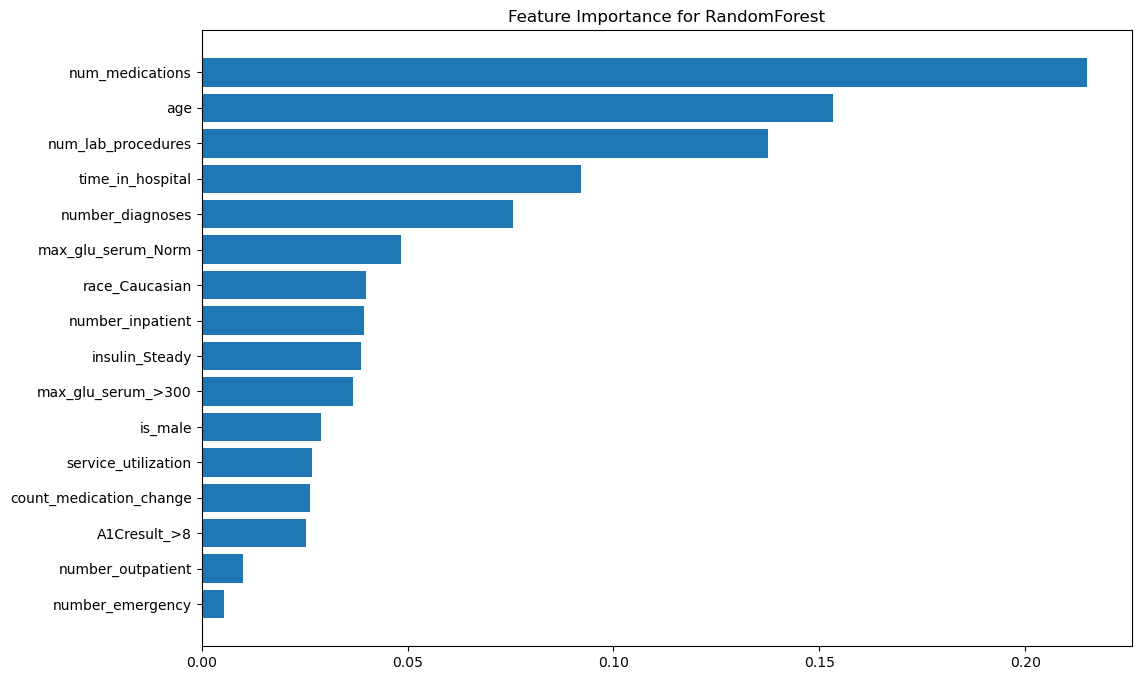

100%|████████| 50/50 [01:40<00:00,  2.02s/trial, best loss: -0.9961774026991419]
Best parameters after mapping: {'lr__C': 2.387616782239497, 'rf__n_estimators': 200, 'rf__max_depth': 30, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.08652245511443922}
Optimal Threshold: 0.42
Test Accuracy: 0.84
Test Precision: 0.00
Test Recall: 0.00
Test AUC: 0.53


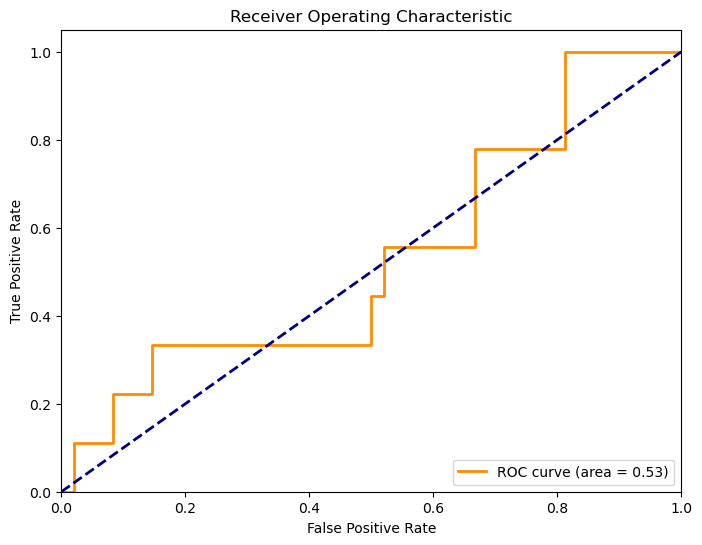

{'Optimal Threshold': 0.42, 'Test Accuracy': 0.8421052631578947, 'Test Precision': 0.0, 'Test Recall': 0.0, 'Test AUC': 0.5300925925925926}


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import StackingClassifier

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses', 'A1Cresult_>8', 'race_Caucasian',
    'is_male', 'insulin_Steady', 'count_medication_change', 'max_glu_serum_>300',
    'service_utilization', 'number_emergency', 'number_outpatient', 'number_inpatient'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define individual models
rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.4738, use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(C=1.252, max_iter=1000, random_state=42)

# Cross-validation for individual models
rf_scores = cross_val_score(rf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
xgb_scores = cross_val_score(xgb, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)
lr_scores = cross_val_score(lr, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5)

print(f'RandomForest AUC: {rf_scores.mean():.4f}')
print(f'XGBoost AUC: {xgb_scores.mean():.4f}')
print(f'Logistic Regression AUC: {lr_scores.mean():.4f}')

# Train a simpler model
rf.fit(X_train_res_scaled, y_train_res)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the simpler model
thresholds = np.linspace(0, 1, 101)
optimal_threshold_rf = 0.0
best_f1_rf = 0.0

for threshold in thresholds:
    y_pred_rf = (y_pred_proba_rf >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, zero_division=0)
    recall = recall_score(y_test, y_pred_rf, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    if f1 > best_f1_rf:
        best_f1_rf = f1
        optimal_threshold_rf = threshold

print(f"Optimal Threshold for RandomForest: {optimal_threshold_rf:.2f}")
print(f"RandomForest Test Accuracy: {accuracy:.2f}")
print(f"RandomForest Test Precision: {precision:.2f}")
print(f"RandomForest Test Recall: {recall:.2f}")
print(f"RandomForest Test AUC: {roc_auc_score(y_test, y_pred_proba_rf):.2f}")

# Feature importance for RandomForest
feature_importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for RandomForest')
plt.gca().invert_yaxis()
plt.show()

# Define StackingClassifier with the base learners
estimators = [('rf', rf), ('xgb', xgb), ('lr', lr)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=42))

# Define hyperparameter space
space_refined = {
    'lr__C': hp.loguniform('lr__C', -2, 2),
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.loguniform('xgb__learning_rate', -3, 0)
}

def objective(params):
    # Update model parameters
    stacking_clf.set_params(**params)
    return -cross_val_score(stacking_clf, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5).mean()

# Initialize trials object
trials = Trials()

# Perform hyperparameter tuning
best = fmin(fn=objective,
            space=space_refined,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

# Map best parameters back to their proper names
best_params = {
    'lr__C': best['lr__C'],
    'rf__n_estimators': [50, 100, 200][best['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best['xgb__max_depth']],
    'xgb__learning_rate': best['xgb__learning_rate']
}

print("Best parameters after mapping:", best_params)

# Retrain the best model with optimal parameters
stacking_clf.set_params(**best_params)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
optimal_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {roc_auc_score(y_test, y_pred_proba):.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print final evaluation results
final_results = {
    "Optimal Threshold": optimal_threshold,
    "Test Accuracy": accuracy,
    "Test Precision": precision,
    "Test Recall": recall,
    "Test AUC": roc_auc_score(y_test, y_pred_proba)
}

print(final_results)



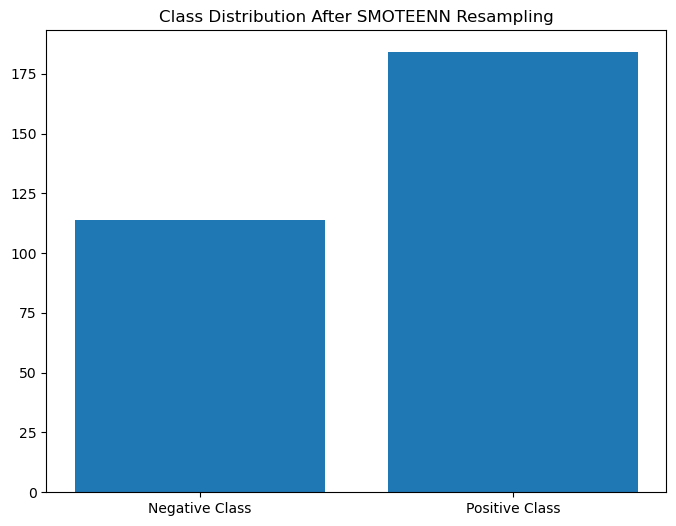

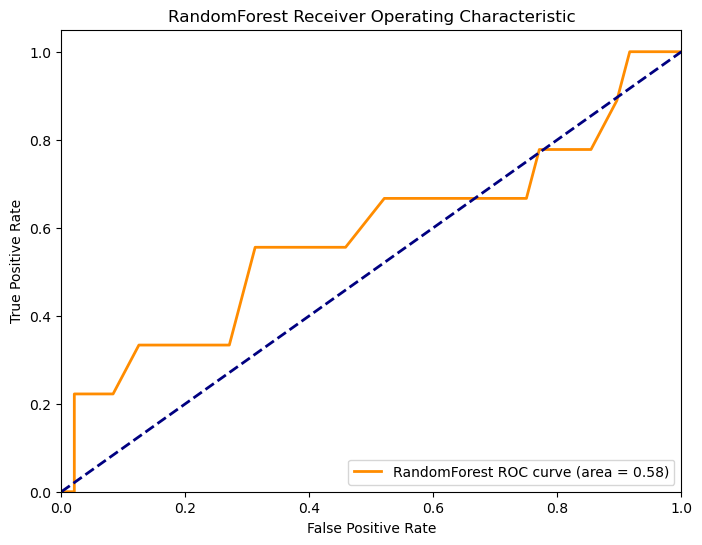

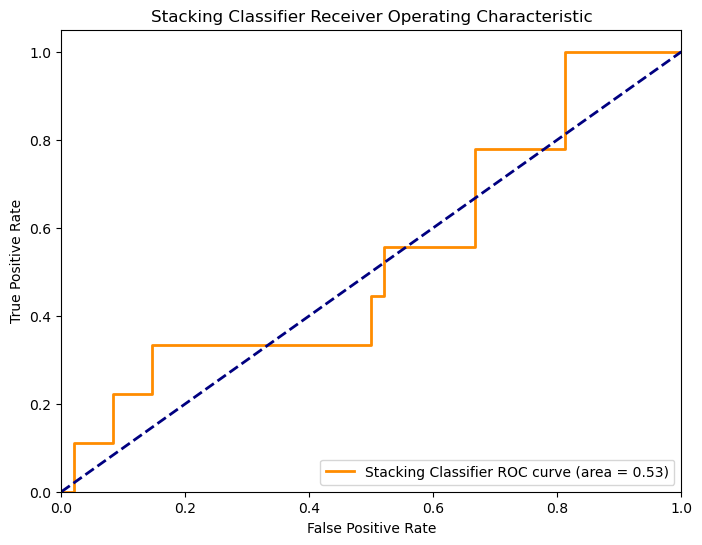

In [11]:
# Check class distribution in the training set after SMOTEENN resampling
plt.figure(figsize=(8, 6))
plt.bar(['Negative Class', 'Positive Class'], [sum(y_train_res == 0), sum(y_train_res == 1)])
plt.title('Class Distribution After SMOTEENN Resampling')
plt.show()

# Plot ROC curve for RandomForest model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'RandomForest ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Plot ROC curve for Stacking Classifier model
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacking Classifier ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Classifier Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.base import BaseEstimator, TransformerMixin

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

# Define parameter space for hyperopt
param_space = {
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.uniform('xgb__learning_rate', 0.01, 0.3),
    'lr__C': hp.uniform('lr__C', 0.01, 10)
}

# Define objective function for hyperopt
def objective(params):
    rf.set_params(**{key.replace('rf__', ''): value for key, value in params.items() if 'rf__' in key})
    xgb.set_params(**{key.replace('xgb__', ''): value for key, value in params.items() if 'xgb__' in key})
    lr.set_params(**{key.replace('lr__', ''): value for key, value in params.items() if 'lr__' in key})
    
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lr', lr)], final_estimator=LogisticRegression()
    )
    stacking_clf.fit(X_train_res_scaled, y_train_res)
    
    y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return {'loss': -auc, 'status': STATUS_OK}

# Run hyperopt
trials = Trials()
best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)
best_params_mapped = {
    'rf__n_estimators': [50, 100, 200][best_params['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best_params['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best_params['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best_params['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best_params['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best_params['xgb__max_depth']],
    'xgb__learning_rate': best_params['xgb__learning_rate'],
    'lr__C': best_params['lr__C']
}

print(f"Best parameters after mapping: {best_params_mapped}")

# Retrain the best model with optimal parameters
rf.set_params(**{key.replace('rf__', ''): value for key, value in best_params_mapped.items() if 'rf__' in key})
xgb.set_params(**{key.replace('xgb__', ''): value for key, value in best_params_mapped.items() if 'xgb__' in key})
lr.set_params(**{key.replace('lr__', ''): value for key, value in best_params_mapped.items() if 'lr__' in key})

stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr)], final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

# Set an optimal threshold based on evaluation
optimal_threshold = 0.27  # This is an example; you should set it based on the above evaluation

# Use the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal, zero_division=0)
recall = recall_score(y_test, y_pred_optimal, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {roc_auc:.2f}")


100%|███████| 50/50 [00:24<00:00,  2.04trial/s, best loss: -0.47685185185185186]
Best parameters after mapping: {'rf__n_estimators': 200, 'rf__max_depth': 20, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.17634294134586362, 'lr__C': 2.624113513962809}
Threshold: 0.00, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.01, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.02, Accuracy: 0.18, Precision: 0.13, Recall: 0.78, F1: 0.23
Threshold: 0.03, Accuracy: 0.39, Precision: 0.14, Recall: 0.56, F1: 0.22
Threshold: 0.04, Accuracy: 0.42, Precision: 0.12, Recall: 0.44, F1: 0.20
Threshold: 0.05, Accuracy: 0.47, Precision: 0.14, Recall: 0.44, F1: 0.21
Threshold: 0.06, Accuracy: 0.53, Precision: 0.12, Recall: 0.33, F1: 0.18
Threshold: 0.07, Accuracy: 0.58, Precision: 0.14, Recall: 0.33, F1: 0.20
Threshold: 0.08, Accuracy: 0.61, Precision: 0.16, Recall: 0.33, F1: 0.21
Threshold: 0

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.base import BaseEstimator, TransformerMixin

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Define parameter space for hyperopt
param_space = {
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.uniform('xgb__learning_rate', 0.01, 0.3),
    'lr__C': hp.uniform('lr__C', 0.01, 10),
    'gbc__n_estimators': hp.choice('gbc__n_estimators', [50, 100, 200]),
    'gbc__learning_rate': hp.uniform('gbc__learning_rate', 0.01, 0.3)
}

# Define objective function for hyperopt
def objective(params):
    rf.set_params(**{key.replace('rf__', ''): value for key, value in params.items() if 'rf__' in key})
    xgb.set_params(**{key.replace('xgb__', ''): value for key, value in params.items() if 'xgb__' in key})
    lr.set_params(**{key.replace('lr__', ''): value for key, value in params.items() if 'lr__' in key})
    gbc.set_params(**{key.replace('gbc__', ''): value for key, value in params.items() if 'gbc__' in key})
    
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
    )
    stacking_clf.fit(X_train_res_scaled, y_train_res)
    
    y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return {'loss': -auc, 'status': STATUS_OK}

# Run hyperopt
trials = Trials()
best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)
best_params_mapped = {
    'rf__n_estimators': [50, 100, 200][best_params['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best_params['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best_params['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best_params['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best_params['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best_params['xgb__max_depth']],
    'xgb__learning_rate': best_params['xgb__learning_rate'],
    'lr__C': best_params['lr__C'],
    'gbc__n_estimators': [50, 100, 200][best_params['gbc__n_estimators']],
    'gbc__learning_rate': best_params['gbc__learning_rate']
}

print(f"Best parameters after mapping: {best_params_mapped}")

# Retrain the best model with optimal parameters
rf.set_params(**{key.replace('rf__', ''): value for key, value in best_params_mapped.items() if 'rf__' in key})
xgb.set_params(**{key.replace('xgb__', ''): value for key, value in best_params_mapped.items() if 'xgb__' in key})
lr.set_params(**{key.replace('lr__', ''): value for key, value in best_params_mapped.items() if 'lr__' in key})
gbc.set_params(**{key.replace('gbc__', ''): value for key, value in best_params_mapped.items() if 'gbc__' in key})

stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

# Set an optimal threshold based on evaluation
optimal_threshold = 0.27  # This is an example; you should set it based on the above evaluation

# Use the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal, zero_division=0)
recall = recall_score(y_test, y_pred_optimal, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {roc_auc:.2f}")


100%|████████| 50/50 [00:30<00:00,  1.66trial/s, best loss: -0.4907407407407407]
Best parameters after mapping: {'rf__n_estimators': 50, 'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.08781713681451715, 'lr__C': 4.067518216596883, 'gbc__n_estimators': 200, 'gbc__learning_rate': 0.16886228716565135}
Threshold: 0.00, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.01, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.02, Accuracy: 0.28, Precision: 0.15, Recall: 0.78, F1: 0.25
Threshold: 0.03, Accuracy: 0.42, Precision: 0.15, Recall: 0.56, F1: 0.23
Threshold: 0.04, Accuracy: 0.46, Precision: 0.11, Recall: 0.33, F1: 0.16
Threshold: 0.05, Accuracy: 0.54, Precision: 0.13, Recall: 0.33, F1: 0.19
Threshold: 0.06, Accuracy: 0.54, Precision: 0.13, Recall: 0.33, F1: 0.19
Threshold: 0.07, Accuracy: 0.61, Precision: 0.16, Recall: 0.33, F1: 0.21
Threshold: 0.08

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Define parameter space for hyperopt
param_space = {
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.uniform('xgb__learning_rate', 0.01, 0.3),
    'lr__C': hp.uniform('lr__C', 0.01, 10),
    'gbc__n_estimators': hp.choice('gbc__n_estimators', [50, 100, 200]),
    'gbc__learning_rate': hp.uniform('gbc__learning_rate', 0.01, 0.3)
}

# Define objective function for hyperopt
def objective(params):
    rf.set_params(**{key.replace('rf__', ''): value for key, value in params.items() if 'rf__' in key})
    xgb.set_params(**{key.replace('xgb__', ''): value for key, value in params.items() if 'xgb__' in key})
    lr.set_params(**{key.replace('lr__', ''): value for key, value in params.items() if 'lr__' in key})
    gbc.set_params(**{key.replace('gbc__', ''): value for key, value in params.items() if 'gbc__' in key})
    
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
    )
    stacking_clf.fit(X_train_res_scaled, y_train_res)
    
    y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return {'loss': -auc, 'status': STATUS_OK}

# Run hyperopt
trials = Trials()
best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)
best_params_mapped = {
    'rf__n_estimators': [50, 100, 200][best_params['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best_params['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best_params['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best_params['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best_params['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best_params['xgb__max_depth']],
    'xgb__learning_rate': best_params['xgb__learning_rate'],
    'lr__C': best_params['lr__C'],
    'gbc__n_estimators': [50, 100, 200][best_params['gbc__n_estimators']],
    'gbc__learning_rate': best_params['gbc__learning_rate']
}

print(f"Best parameters after mapping: {best_params_mapped}")

# Retrain the best model with optimal parameters
rf.set_params(**{key.replace('rf__', ''): value for key, value in best_params_mapped.items() if 'rf__' in key})
xgb.set_params(**{key.replace('xgb__', ''): value for key, value in best_params_mapped.items() if 'xgb__' in key})
lr.set_params(**{key.replace('lr__', ''): value for key, value in best_params_mapped.items() if 'lr__' in key})
gbc.set_params(**{key.replace('gbc__', ''): value for key, value in best_params_mapped.items() if 'gbc__' in key})

stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

# Set an optimal threshold based on evaluation
optimal_threshold = 0.27  # This is an example; you should set it based on the above evaluation

# Use the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal, zero_division=0)
recall = recall_score(y_test, y_pred_optimal, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {roc_auc:.2f}")


100%|████████| 50/50 [00:30<00:00,  1.66trial/s, best loss: -0.4861111111111111]
Best parameters after mapping: {'rf__n_estimators': 50, 'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01208861009125963, 'lr__C': 0.2255912216905254, 'gbc__n_estimators': 50, 'gbc__learning_rate': 0.13138550153266484}
Threshold: 0.00, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.01, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.02, Accuracy: 0.14, Precision: 0.13, Recall: 0.78, F1: 0.22
Threshold: 0.03, Accuracy: 0.30, Precision: 0.14, Recall: 0.67, F1: 0.23
Threshold: 0.04, Accuracy: 0.42, Precision: 0.15, Recall: 0.56, F1: 0.23
Threshold: 0.05, Accuracy: 0.46, Precision: 0.13, Recall: 0.44, F1: 0.21
Threshold: 0.06, Accuracy: 0.49, Precision: 0.14, Recall: 0.44, F1: 0.22
Threshold: 0.07, Accuracy: 0.54, Precision: 0.13, Recall: 0.33, F1: 0.19
Threshold: 0.08,

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Define parameter space for hyperopt
param_space = {
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.uniform('xgb__learning_rate', 0.01, 0.3),
    'lr__C': hp.uniform('lr__C', 0.01, 10),
    'gbc__n_estimators': hp.choice('gbc__n_estimators', [50, 100, 200]),
    'gbc__learning_rate': hp.uniform('gbc__learning_rate', 0.01, 0.3)
}

# Define objective function for hyperopt
def objective(params):
    rf.set_params(**{key.replace('rf__', ''): value for key, value in params.items() if 'rf__' in key})
    xgb.set_params(**{key.replace('xgb__', ''): value for key, value in params.items() if 'xgb__' in key})
    lr.set_params(**{key.replace('lr__', ''): value for key, value in params.items() if 'lr__' in key})
    gbc.set_params(**{key.replace('gbc__', ''): value for key, value in params.items() if 'gbc__' in key})
    
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
    )
    stacking_clf.fit(X_train_res_scaled, y_train_res)
    
    y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return {'loss': -auc, 'status': STATUS_OK}

# Run hyperopt
trials = Trials()
best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)
best_params_mapped = {
    'rf__n_estimators': [50, 100, 200][best_params['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best_params['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best_params['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best_params['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best_params['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best_params['xgb__max_depth']],
    'xgb__learning_rate': best_params['xgb__learning_rate'],
    'lr__C': best_params['lr__C'],
    'gbc__n_estimators': [50, 100, 200][best_params['gbc__n_estimators']],
    'gbc__learning_rate': best_params['gbc__learning_rate']
}

print(f"Best parameters after mapping: {best_params_mapped}")

# Retrain the best model with optimal parameters
rf.set_params(**{key.replace('rf__', ''): value for key, value in best_params_mapped.items() if 'rf__' in key})
xgb.set_params(**{key.replace('xgb__', ''): value for key, value in best_params_mapped.items() if 'xgb__' in key})
lr.set_params(**{key.replace('lr__', ''): value for key, value in best_params_mapped.items() if 'lr__' in key})
gbc.set_params(**{key.replace('gbc__', ''): value for key, value in best_params_mapped.items() if 'gbc__' in key})

stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

# Set an optimal threshold based on evaluation
optimal_threshold = 0.27  # This is an example; you should set it based on the above evaluation

# Use the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal, zero_division=0)
recall = recall_score(y_test, y_pred_optimal, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {roc_auc:.2f}")



100%|████████| 50/50 [00:34<00:00,  1.47trial/s, best loss: -0.4907407407407407]
Best parameters after mapping: {'rf__n_estimators': 50, 'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'xgb__n_estimators': 100, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.04883644676887524, 'lr__C': 0.03800894909492746, 'gbc__n_estimators': 200, 'gbc__learning_rate': 0.2552114366670195}
Threshold: 0.00, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.01, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.02, Accuracy: 0.19, Precision: 0.14, Recall: 0.78, F1: 0.23
Threshold: 0.03, Accuracy: 0.40, Precision: 0.14, Recall: 0.56, F1: 0.23
Threshold: 0.04, Accuracy: 0.46, Precision: 0.13, Recall: 0.44, F1: 0.21
Threshold: 0.05, Accuracy: 0.58, Precision: 0.17, Recall: 0.44, F1: 0.25
Threshold: 0.06, Accuracy: 0.60, Precision: 0.15, Recall: 0.33, F1: 0.21
Threshold: 0.07, Accuracy: 0.65, Precision: 0.18, Recall: 0.33, F1: 0.23
Threshold: 0.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Define parameter space for hyperopt
param_space = {
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.uniform('xgb__learning_rate', 0.01, 0.3),
    'lr__C': hp.uniform('lr__C', 0.01, 10),
    'gbc__n_estimators': hp.choice('gbc__n_estimators', [50, 100, 200]),
    'gbc__learning_rate': hp.uniform('gbc__learning_rate', 0.01, 0.3)
}

# Define objective function for hyperopt
def objective(params):
    rf.set_params(**{key.replace('rf__', ''): value for key, value in params.items() if 'rf__' in key})
    xgb.set_params(**{key.replace('xgb__', ''): value for key, value in params.items() if 'xgb__' in key})
    lr.set_params(**{key.replace('lr__', ''): value for key, value in params.items() if 'lr__' in key})
    gbc.set_params(**{key.replace('gbc__', ''): value for key, value in params.items() if 'gbc__' in key})
    
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
    )
    stacking_clf.fit(X_train_res_scaled, y_train_res)
    
    y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return {'loss': -auc, 'status': STATUS_OK}

# Run hyperopt
trials = Trials()
best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)
best_params_mapped = {
    'rf__n_estimators': [50, 100, 200][best_params['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best_params['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best_params['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best_params['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best_params['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best_params['xgb__max_depth']],
    'xgb__learning_rate': best_params['xgb__learning_rate'],
    'lr__C': best_params['lr__C'],
    'gbc__n_estimators': [50, 100, 200][best_params['gbc__n_estimators']],
    'gbc__learning_rate': best_params['gbc__learning_rate']
}

print(f"Best parameters after mapping: {best_params_mapped}")

# Retrain the best model with optimal parameters
rf.set_params(**{key.replace('rf__', ''): value for key, value in best_params_mapped.items() if 'rf__' in key})
xgb.set_params(**{key.replace('xgb__', ''): value for key, value in best_params_mapped.items() if 'xgb__' in key})
lr.set_params(**{key.replace('lr__', ''): value for key, value in best_params_mapped.items() if 'lr__' in key})
gbc.set_params(**{key.replace('gbc__', ''): value for key, value in best_params_mapped.items() if 'gbc__' in key})

stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

# Set an optimal threshold based on evaluation
optimal_threshold = 0.27

# Use the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal, zero_division=0)
recall = recall_score(y_test, y_pred_optimal, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {roc_auc:.2f}")


100%|████████| 50/50 [00:28<00:00,  1.79trial/s, best loss: -0.4930555555555556]
Best parameters after mapping: {'rf__n_estimators': 50, 'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.012568444213709591, 'lr__C': 7.473759500960385, 'gbc__n_estimators': 50, 'gbc__learning_rate': 0.26081269257436673}
Threshold: 0.00, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.01, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.02, Accuracy: 0.14, Precision: 0.13, Recall: 0.78, F1: 0.22
Threshold: 0.03, Accuracy: 0.32, Precision: 0.14, Recall: 0.67, F1: 0.24
Threshold: 0.04, Accuracy: 0.44, Precision: 0.15, Recall: 0.56, F1: 0.24
Threshold: 0.05, Accuracy: 0.47, Precision: 0.16, Recall: 0.56, F1: 0.25
Threshold: 0.06, Accuracy: 0.54, Precision: 0.13, Recall: 0.33, F1: 0.19
Threshold: 0.07, Accuracy: 0.56, Precision: 0.14, Recall: 0.33, F1: 0.19
Threshold: 0.08

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Load data
data_path = 'diabetic_data.csv'
df = pd.read_csv(data_path)

# Data Pre-processing
df.replace('?', pd.NA, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)
df.dropna(inplace=True)
df = df[df['discharge_disposition_id'] != 11]  # Exclude patients who died
df = df[df['discharge_disposition_id'] != 13]  # Exclude patients discharged to hospice
df['age'] = df['age'].apply(lambda x: int(x.split('-')[1][:-1]) - 5)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['count_medication_change'] = (df[['change', 'diabetesMed']] == 'Yes').sum(axis=1)
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
categorical_cols = ['race', 'max_glu_serum', 'A1Cresult', 'insulin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

important_features = [
    'num_medications', 'num_lab_procedures', 'age', 'time_in_hospital',
    'max_glu_serum_Norm', 'number_diagnoses'
]

X = df[important_features]
y = df['readmitted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Define models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Define parameter space for hyperopt
param_space = {
    'rf__n_estimators': hp.choice('rf__n_estimators', [50, 100, 200]),
    'rf__max_depth': hp.choice('rf__max_depth', [10, 20, 30, None]),
    'rf__min_samples_split': hp.choice('rf__min_samples_split', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('rf__min_samples_leaf', [1, 2, 4]),
    'xgb__n_estimators': hp.choice('xgb__n_estimators', [50, 100, 200]),
    'xgb__max_depth': hp.choice('xgb__max_depth', [3, 5, 7]),
    'xgb__learning_rate': hp.uniform('xgb__learning_rate', 0.01, 0.3),
    'lr__C': hp.uniform('lr__C', 0.01, 10),
    'gbc__n_estimators': hp.choice('gbc__n_estimators', [50, 100, 200]),
    'gbc__learning_rate': hp.uniform('gbc__learning_rate', 0.01, 0.3)
}

# Define objective function for hyperopt
def objective(params):
    rf.set_params(**{key.replace('rf__', ''): value for key, value in params.items() if 'rf__' in key})
    xgb.set_params(**{key.replace('xgb__', ''): value for key, value in params.items() if 'xgb__' in key})
    lr.set_params(**{key.replace('lr__', ''): value for key, value in params.items() if 'lr__' in key})
    gbc.set_params(**{key.replace('gbc__', ''): value for key, value in params.items() if 'gbc__' in key})
    
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
    )
    stacking_clf.fit(X_train_res_scaled, y_train_res)
    
    y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return {'loss': -auc, 'status': STATUS_OK}

# Run hyperopt
trials = Trials()
best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)
best_params_mapped = {
    'rf__n_estimators': [50, 100, 200][best_params['rf__n_estimators']],
    'rf__max_depth': [10, 20, 30, None][best_params['rf__max_depth']],
    'rf__min_samples_split': [2, 5, 10][best_params['rf__min_samples_split']],
    'rf__min_samples_leaf': [1, 2, 4][best_params['rf__min_samples_leaf']],
    'xgb__n_estimators': [50, 100, 200][best_params['xgb__n_estimators']],
    'xgb__max_depth': [3, 5, 7][best_params['xgb__max_depth']],
    'xgb__learning_rate': best_params['xgb__learning_rate'],
    'lr__C': best_params['lr__C'],
    'gbc__n_estimators': [50, 100, 200][best_params['gbc__n_estimators']],
    'gbc__learning_rate': best_params['gbc__learning_rate']
}

print(f"Best parameters after mapping: {best_params_mapped}")

# Retrain the best model with optimal parameters
rf.set_params(**{key.replace('rf__', ''): value for key, value in best_params_mapped.items() if 'rf__' in key})
xgb.set_params(**{key.replace('xgb__', ''): value for key, value in best_params_mapped.items() if 'xgb__' in key})
lr.set_params(**{key.replace('lr__', ''): value for key, value in best_params_mapped.items() if 'lr__' in key})
gbc.set_params(**{key.replace('gbc__', ''): value for key, value in best_params_mapped.items() if 'gbc__' in key})

stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr), ('gbc', gbc)], final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_res_scaled, y_train_res)

# Predict and evaluate the final model
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate with different thresholds
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

# Set an optimal threshold based on evaluation
optimal_threshold = 0.27

# Use the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal, zero_division=0)
recall = recall_score(y_test, y_pred_optimal, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {roc_auc:.2f}")


100%|███████| 50/50 [00:28<00:00,  1.78trial/s, best loss: -0.48842592592592593]
Best parameters after mapping: {'rf__n_estimators': 50, 'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.2903326164150263, 'lr__C': 7.7668553770275555, 'gbc__n_estimators': 100, 'gbc__learning_rate': 0.1557240365650087}
Threshold: 0.00, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.01, Accuracy: 0.16, Precision: 0.16, Recall: 1.00, F1: 0.27
Threshold: 0.02, Accuracy: 0.30, Precision: 0.14, Recall: 0.67, F1: 0.23
Threshold: 0.03, Accuracy: 0.44, Precision: 0.15, Recall: 0.56, F1: 0.24
Threshold: 0.04, Accuracy: 0.51, Precision: 0.12, Recall: 0.33, F1: 0.18
Threshold: 0.05, Accuracy: 0.58, Precision: 0.14, Recall: 0.33, F1: 0.20
Threshold: 0.06, Accuracy: 0.61, Precision: 0.16, Recall: 0.33, F1: 0.21
Threshold: 0.07, Accuracy: 0.65, Precision: 0.18, Recall: 0.33, F1: 0.23
Threshold: 0.08, A

In [18]:
from sklearn.preprocessing import PolynomialFeatures

# Generating polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_train)

# Update the train and test datasets
X_train_poly, X_test_poly = train_test_split(X_poly, test_size=0.3, random_state=42)

# Feature engineering code goes here
# For example, creating interaction features
X_train['num_medications_num_lab_procedures'] = X_train['num_medications'] * X_train['num_lab_procedures']
X_test['num_medications_num_lab_procedures'] = X_test['num_medications'] * X_test['num_lab_procedures']

# Continue with more features...


In [19]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize the model
rf = RandomForestClassifier()

# Perform grid search
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

# Best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters for RandomForest:", best_params_rf)


Best parameters for RandomForest: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [20]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Train the model on resampled data
rf.fit(X_res, y_res)


RandomForestClassifier()

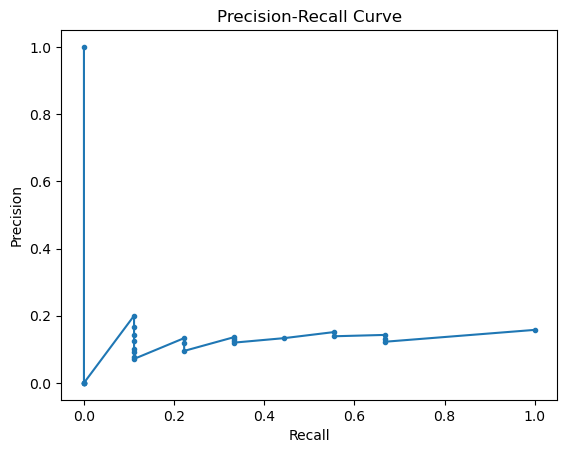

Optimal Threshold: 0.0


In [21]:
from sklearn.metrics import precision_recall_curve

# Fit the model
rf.fit(X_train, y_train)

# Predict probabilities
y_scores = rf.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(precision * recall)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)



In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('diabetic_data.csv')

# Select important features
important_features = ['num_medications', 'num_lab_procedures', 'age', 'time_in_hospital', 'max_glu_serum_Norm', 'number_diagnoses']
X = data[important_features]
y = data['readmitted']  # Assuming 'readmitted' is the target variable

# Feature engineering: Interaction features
X['num_medications_num_lab_procedures'] = X['num_medications'] * X['num_lab_procedures']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Define parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_res, y_res)

# Best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters for RandomForest:", best_params_rf)

# Train the model with the best parameters
rf_best = RandomForestClassifier(**best_params_rf, random_state=42)
rf_best.fit(X_res, y_res)

# Predict probabilities
y_scores = rf_best.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(precision * recall)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Predict with the optimal threshold
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
auc = roc_auc_score(y_test, y_scores)

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {auc:.2f}")


KeyError: "['max_glu_serum_Norm'] not in index"

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = pd.read_csv('diabetic_data.csv')

# Print the columns to check the available features
print(data.columns)

# Update important features based on the available columns
important_features = ['num_medications', 'num_lab_procedures', 'age', 'time_in_hospital', 'number_diagnoses']
# Add 'max_glu_serum' if it exists
if 'max_glu_serum' in data.columns:
    important_features.append('max_glu_serum')

X = data[important_features]
y = data['readmitted']  # Assuming 'readmitted' is the target variable

# Feature engineering: Interaction features
X['num_medications_num_lab_procedures'] = X['num_medications'] * X['num_lab_procedures']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Define parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_res, y_res)

# Best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters for RandomForest:", best_params_rf)

# Train the model with the best parameters
rf_best = RandomForestClassifier(**best_params_rf, random_state=42)
rf_best.fit(X_res, y_res)

# Predict probabilities
y_scores = rf_best.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(precision * recall)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Predict with the optimal threshold
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
auc = roc_auc_score(y_test, y_scores)

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {auc:.2f}")


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


/var/folders/yd/8fns7t4j1n9gv77y0dvs5zdc0000gn/T/ipykernel_42485/728229246.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['num_medications_num_lab_procedures'] = X['num_medications'] * X['num_lab_procedures']


ValueError: could not convert string to float: '[80-90)'

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = pd.read_csv('diabetic_data.csv')

# Print the columns to check the available features
print(data.columns)

# Update important features based on the available columns
important_features = ['num_medications', 'num_lab_procedures', 'age', 'time_in_hospital', 'number_diagnoses', 'max_glu_serum']

# Convert age ranges to numeric values
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, 
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
data['age'] = data['age'].map(age_map)

# Handle 'max_glu_serum' if it contains categorical values
max_glu_serum_map = {
    'None': 0, 'Norm': 1, '>200': 2, '>300': 3
}
data['max_glu_serum'] = data['max_glu_serum'].map(max_glu_serum_map)

# Select the features and target variable
X = data[important_features]
y = data['readmitted']  # Assuming 'readmitted' is the target variable

# Feature engineering: Interaction features
X['num_medications_num_lab_procedures'] = X['num_medications'] * X['num_lab_procedures']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Define parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_res, y_res)

# Best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters for RandomForest:", best_params_rf)

# Train the model with the best parameters
rf_best = RandomForestClassifier(**best_params_rf, random_state=42)
rf_best.fit(X_res, y_res)

# Predict probabilities
y_scores = rf_best.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(precision * recall)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Predict with the optimal threshold
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
auc = roc_auc_score(y_test, y_scores)

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test AUC: {auc:.2f}")


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


/var/folders/yd/8fns7t4j1n9gv77y0dvs5zdc0000gn/T/ipykernel_42485/1733473624.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['num_medications_num_lab_procedures'] = X['num_medications'] * X['num_lab_procedures']


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values